In [1]:
# import needed modules
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Step 01

## B

In [2]:
# reading the data
data_dir = os.path.join("CCPP", "Folds5x2_pp.xlsx")
df = pd.read_excel(data_dir, sheet_name="Sheet1")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


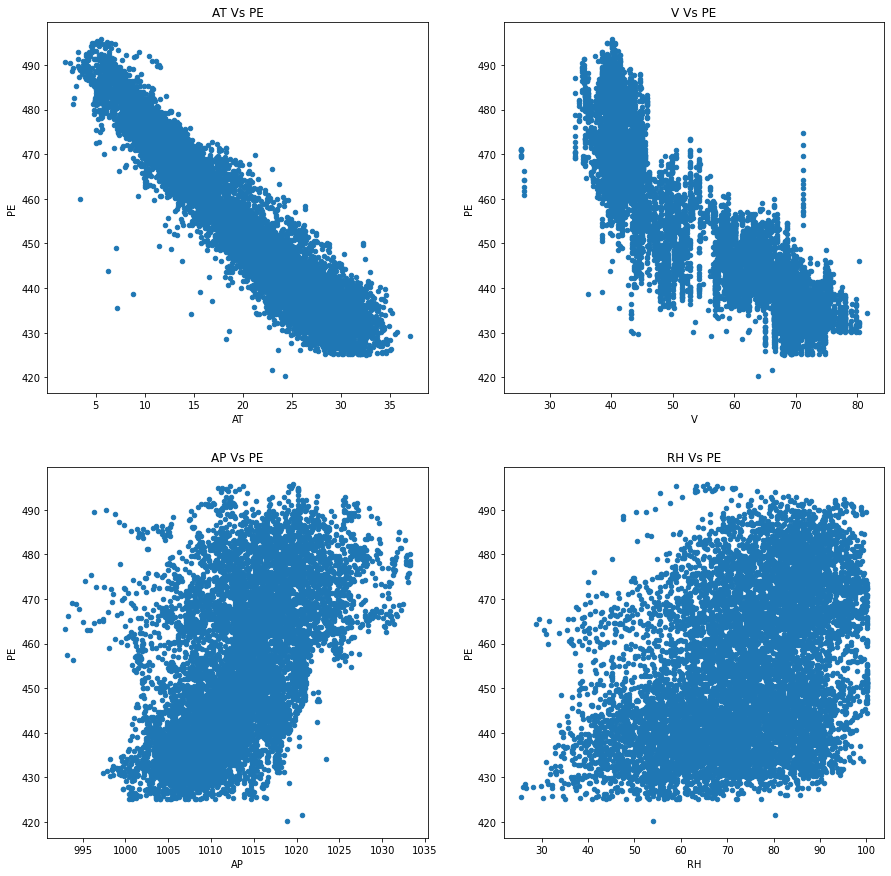

In [3]:
# visualize the data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
df.plot.scatter(ax=axes[0,0], x='AT', y='PE', title="AT Vs PE")
df.plot.scatter(ax=axes[0,1], x='V',  y='PE', title="V Vs PE")
df.plot.scatter(ax=axes[1,0], x='AP', y='PE', title="AP Vs PE")
df.plot.scatter(ax=axes[1,1], x='RH', y='PE', title="RH Vs PE")

plt.show()

**Question:**

Which features are most predictive? Why do you think so?

***Answer***

I think the most predictive feature is `AT` as there is a strong correlation between `AT` and `PE` according ot the plotted scatter plots.

## C

In [4]:
def normalize_data(arr):
    """
    Standarizes the given numpy.array.
    
    Parameters
    ----------
    arr: numpy.array
        A numpy array containing the features of our data
    
    Returns
    -------
    numpy.array:
        A numpy array containing the normalized features.
    """
    mu = np.mean(arr, axis=0)
    sigma = np.std(arr, axis=0)
    return (arr-mu)/sigma

In [5]:
def preprocess_data(df):
    # remove duplicates / missing values
    df = df.drop_duplicates().dropna()
    # shuffle dataset
    df = df.sample(frac=1, random_state=42)
    # get features and labels
    X = df.drop("PE", axis=1).values    
    Y = df["PE"].values.reshape(len(df), 1)
    # normalize X
    X = normalize_data(X)
#     # adding bias for X
#     X = np.c_[X, np.ones(len(X))]
    return X, Y

In [6]:
def split_data(df, split_ratio=0.2):
    """
    A simple function to split the dataset into two smaller sets:
    - train_set: (1-split_ratio) of the whole dataset.
    - test_set : (split_ratio) of the whole dataset.
    
    Parameters
    ----------
    df: pandas.DataFrame
        The dataframe containg the whole dataset.
    split_ratio: float
        The ratio of test dataset (default: 20%)
    
    Returns
    -------
    x_train: numpy.array
        A numpy array containing the train features.
    x_test: numpy.array
        A numpy array containing the test features.
    y_train: numpy.array
        A numpy array containing the train labels.
    y_test: numpy.array
        A numpy array containing the test labels.
    """
    X, Y = preprocess_data(df)
    # split
    idx = len(df) - int(split_ratio * len(df))
    X_train, X_test = X[:idx], X[idx:]
    Y_train, Y_test = Y[:idx], Y[idx:]
    return X_train, X_test, Y_train, Y_test

In [7]:
X_train, X_test, Y_train, Y_test = split_data(df, split_ratio=0.2)

print("Train Features Shape:", X_train.shape)
print("Train Labels Shape  :", Y_train.shape)
print("Test Features Shape :", X_test.shape)
print("Test Labels Shape   :", Y_test.shape)

Train Features Shape: (7655, 4)
Train Labels Shape  : (7655, 1)
Test Features Shape : (1872, 4)
Test Labels Shape   : (1872, 1)


In [8]:
def plot_learning_curve(costs, title):
    # plot learning curve
    plt.plot(costs)
    plt.xlabel("# batches")
    plt.ylabel("cost")
    plt.title(title)
    plt.show()

# Step 02

Considering the following linear hypothesis function:

$$h_i = x_i \theta + b_i $$

Mean Squared Error:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (h_i - y_i)^2$$

$$\nabla MSE = \frac{1}{n} \sum_{i=1}^{n} x_i (h_i - y_i)$$


## D

In [9]:
class LinearRegression:
    
    def __init__(self, max_iters=1000, lr=0.001, tolerance=0.00001, batch_size=32):
        self._max_iters = max_iters
        self._lr = lr
        self._tolerance = tolerance
        self._batch_size = batch_size
        # other random variables
        self._theta = None
        self._bias = None
    
    def mse_loss(self, h, y):
        return np.mean((h - y)**2)
    
    def d_theta(self, x, h, y):
        # derivative of loss with respect to theta
        n = len(y)
        return (1/n) * x.T@(h - y)
    
    def d_bias(self, h, y):
        # derivative of loss with respect to bias
        n = len(y)
        return (1/n) * np.sum(h - y)
    
    def train(self, x, y):
        costs, weights, biases = [], [], []
        n, d = x.shape
        num_batches = n // self._batch_size
        self._theta = np.random.rand(d, 1)
        self._bias = np.random.rand(1, 1)
        for _ in  range(self._max_iters):
            for batch_idx in range(0, num_batches, self._batch_size):
                # get the batch
                start_idx = batch_idx
                end_idx = batch_idx + self._batch_size
                batch_x = x[start_idx: end_idx]
                batch_y = y[start_idx: end_idx]
                # get predictions
                batch_h = self.predict(batch_x, self._theta, self._bias)
                # calculate the loss
                curr_cost = self.mse_loss(batch_h, batch_y)
                # update weight & bais
                prev_theta, prev_bias = self._theta, self._bias
                self._theta = self._theta - (self._lr * self.d_theta(batch_x, batch_h, batch_y))
                self._bias  = self._bias  - (self._lr * self.d_bias (batch_h, batch_y))
                # save values
                weights.append(self._theta)
                biases.append(self._bias)
                costs.append(curr_cost)
                # check early convergence
                diff = np.sum(abs(prev_theta - self._theta)) + np.sum(abs(prev_bias - self._bias))
                if diff <= self._tolerance:
                    break
            else:
                continue  # Continue if the inner loop wasn't broken.
            break # Inner loop was broken, break the outer.
        return self._theta, costs, weights, biases
    
    def predict(self, x, theta=None, bias=None):
        if theta is None: theta = self._theta
        if bias is None: bias = self._bias
        return x @ theta + bias
        

### Batch Gradient Descent

In [10]:
BGD_model = LinearRegression(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=len(X_train))
BGD_theta, BGD_costs, _, _ = BGD_model.train(X_train, Y_train)

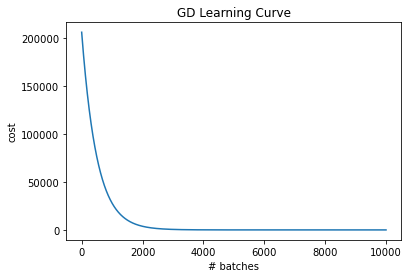

In [11]:
plot_learning_curve(BGD_costs, "GD Learning Curve")

In [12]:
BGD_Y_pred = BGD_model.predict(X_test)
BGD_model.mse_loss(BGD_Y_pred, Y_test)

22.41951947201616

## E

### Stochastic Gradient Descent

In [13]:
SGD_model = LinearRegression(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=1)
SGD_theta, SGD_costs, _, _ = SGD_model.train(X_train, Y_train)

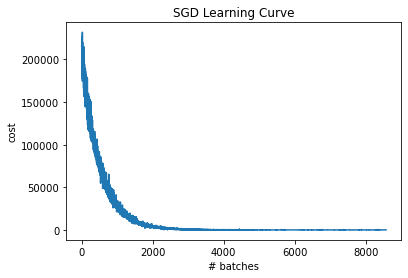

In [14]:
plot_learning_curve(SGD_costs, "SGD Learning Curve")

In [15]:
SGD_Y_pred = SGD_model.predict(X_test, SGD_theta)
SGD_model.mse_loss(SGD_Y_pred, Y_test)

23.168523440950718

## F

### Minibatch Gradient Descent

In [16]:
MBGD_model = LinearRegression(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=32)
MBGD_theta, MBGD_costs, _, _ = MBGD_model.train(X_train, Y_train)

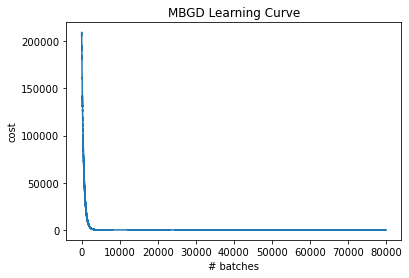

In [17]:
plot_learning_curve(MBGD_costs, "MBGD Learning Curve")

In [18]:
MBGD_Y_pred = MBGD_model.predict(X_test, MBGD_theta)
MBGD_model.mse_loss(MBGD_Y_pred, Y_test)

21.307885282307954

# Step 03

Considering the following linear hypothesis function:

$$h_i = x_i \theta + b_i $$

MSE + L1 Regularization:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (h_i - y_i)^2 + \lambda_1 * \sum_{i=1}^{d} |\theta_i|$$

$$\nabla MSE = \frac{1}{n} \sum_{i=1}^{n} x_i (h_i - y_i) + \lambda_1 *\frac{\theta}{|\theta|}$$


MSE + L2 Regularization:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (h_i - y_i)^2 + \lambda_2 *\sum_{i=1}^{d} (\theta_i)^2$$

$$\nabla MSE = \frac{1}{n} \sum_{i=1}^{n} x_i (h_i - y_i) + \lambda_2 *\theta_i$$


## H

In [19]:
class RegularizedLR(LinearRegression):
    
    def __init__(self, l1_lambda=0, l2_lambda=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._l1_lambda = l1_lambda
        self._l2_lambda = l2_lambda
    
    def mse_loss(self, h, y):
        return super().mse_loss(h, y) + (self._l2_lambda*np.sum(self._theta)**2) + (self._l1_lambda*np.sum(np.abs(self._theta)))
    
    def d_theta(self, x, h, y):
        # derivative of loss with respect to theta
        n = len(y)
        return super().d_theta(x, h, y)  + (self._l2_lambda * self._theta) + (self._l1_lambda * np.sign(self._theta))


### L1 + BGD

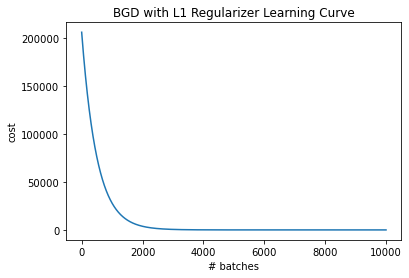

Test MSE: 24.57252297612483


In [20]:
BGD_L1_model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=len(X_train), l1_lambda=0.1)
BGD_L1_theta, BGD_L1_costs, _, _ = BGD_L1_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(BGD_L1_costs, "BGD with L1 Regularizer Learning Curve")
# predict
BGD_L1_Y_pred = BGD_model.predict(X_test, BGD_L1_theta)
print("Test MSE:", BGD_L1_model.mse_loss(BGD_L1_Y_pred, Y_test))

### L2 + BGD

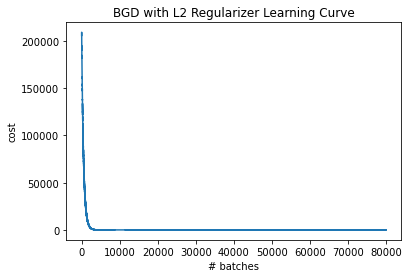

Test MSE: 50.513036908302155


In [21]:
BGD_L2_model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, l2_lambda=0.1)
BGD_L2_theta, BGD_L2_costs, _, _ = BGD_L2_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(BGD_L2_costs, "BGD with L2 Regularizer Learning Curve")
# predict
BGD_L2_Y_pred = BGD_model.predict(X_test, BGD_L2_theta)
print("Test MSE:", BGD_L2_model.mse_loss(BGD_L2_Y_pred, Y_test))

### (L1, L2) + BGD

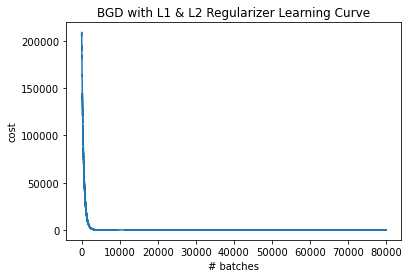

Test MSE: 51.55736109295488


In [22]:
BGD_L1_L2_model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, l1_lambda=0.1, l2_lambda=0.1)
BGD_L1_L2_theta, BGD_L1_L2_costs, _, _ = BGD_L1_L2_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(BGD_L1_L2_costs, "BGD with L1 & L2 Regularizer Learning Curve")
# predict
BGD_L1_L2_Y_pred = BGD_model.predict(X_test, BGD_L1_L2_theta)
print("Test MSE:", BGD_L1_L2_model.mse_loss(BGD_L1_L2_Y_pred, Y_test))

### L1 + SGD

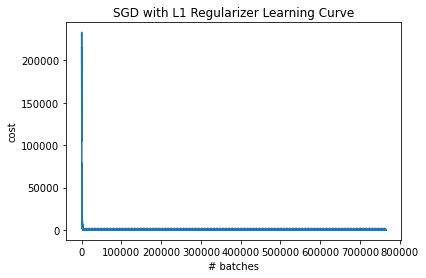

Test MSE: 23.13215546990219


In [23]:
SGD_L1_model = RegularizedLR(max_iters=100, lr=0.001, tolerance=0.00001, batch_size=1, l1_lambda=0.1)
SGD_L1_theta, SGD_L1_costs, _, _ = SGD_L1_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(SGD_L1_costs, "SGD with L1 Regularizer Learning Curve")
# predict
SGD_L1_Y_pred = SGD_model.predict(X_test, SGD_L1_theta)
print("Test MSE:", SGD_L1_model.mse_loss(SGD_L1_Y_pred, Y_test))

### L2 + SGD

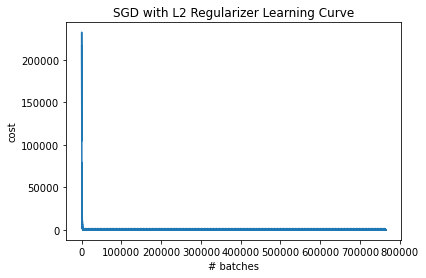

Test MSE: 27.08576563439746


In [24]:
SGD_L2_model = RegularizedLR(max_iters=100, lr=0.001, tolerance=0.00001, batch_size=1, l2_lambda=0.1)
SGD_L2_theta, SGD_L2_costs, _, _ = SGD_L2_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(SGD_L2_costs, "SGD with L2 Regularizer Learning Curve")
# predict
SGD_L1_Y_pred = SGD_model.predict(X_test, SGD_L2_theta)
print("Test MSE:", SGD_L1_model.mse_loss(SGD_L1_Y_pred, Y_test))

### (L1, L2) + SGD

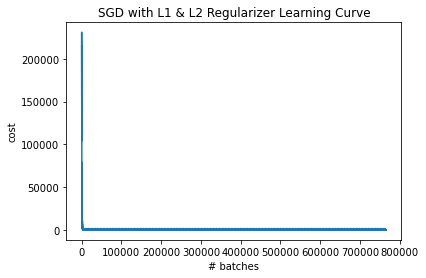

Test MSE: 27.54641427404971


In [25]:
SGD_L1_L2_model = RegularizedLR(max_iters=100, lr=0.001, tolerance=0.00001, batch_size=1, l1_lambda=0.1, l2_lambda=0.1)
SGD_L1_L2_theta, SGD_L1_L2_costs, _, _ = SGD_L1_L2_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(SGD_L1_L2_costs, "SGD with L1 & L2 Regularizer Learning Curve")
# predict
SGD_L1_L2_Y_pred = SGD_model.predict(X_test, SGD_L1_L2_theta)
print("Test MSE:", SGD_L1_model.mse_loss(SGD_L1_L2_Y_pred, Y_test))

### L1 + MBGD

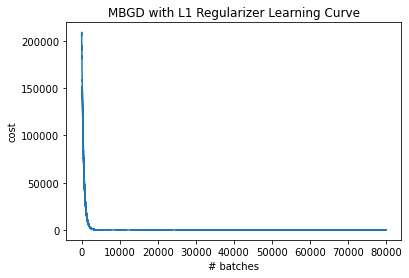

Test MSE: 23.29468945907695


In [26]:
MBGD_L1_model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=32, l1_lambda=0.1)
MBGD_L1_theta, MBGD_L1_costs, _, _ = MBGD_L1_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(MBGD_L1_costs, "MBGD with L1 Regularizer Learning Curve")
# predict
MBGD_L1_Y_pred = MBGD_model.predict(X_test, MBGD_L1_theta)
print("Test MSE:", MBGD_L1_model.mse_loss(MBGD_L1_Y_pred, Y_test))

### L2 + MBGD

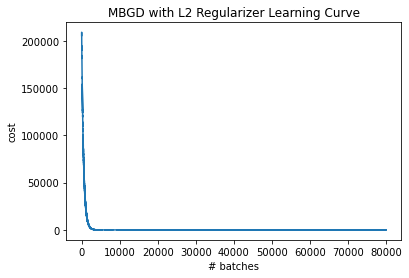

Test MSE: 50.65891975374261


In [27]:
MBGD_L2_model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=32, l2_lambda=0.1)
MBGD_L2_theta, MBGD_L2_costs, _, _ = MBGD_L2_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(MBGD_L2_costs, "MBGD with L2 Regularizer Learning Curve")
# predict
MBGD_L2_Y_pred = MBGD_model.predict(X_test, MBGD_L2_theta)
print("Test MSE:", MBGD_L2_model.mse_loss(MBGD_L2_Y_pred, Y_test))

### (L1, L2) + MBGD

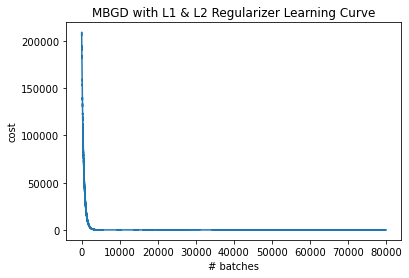

Test MSE: 23.472047218954927


In [28]:
MBGD_L1_L2_model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=32, l1_lambda=0.1, l2_lambda=0.01)
MBGD_L1_L2_theta, MBGD_L1_L2_costs, _, _ = MBGD_L1_L2_model.train(X_train, Y_train)
# plot learning curve
plot_learning_curve(MBGD_L1_L2_costs, "MBGD with L1 & L2 Regularizer Learning Curve")
# predict
MBGD_L1_L2_Y_pred = MBGD_model.predict(X_test, MBGD_L1_L2_theta)
print("Test MSE:", MBGD_L1_model.mse_loss(MBGD_L1_L2_Y_pred, Y_test))

## I

### BGD Vs $\lambda_1$

100%|██████████| 21/21 [02:47<00:00,  7.96s/it]


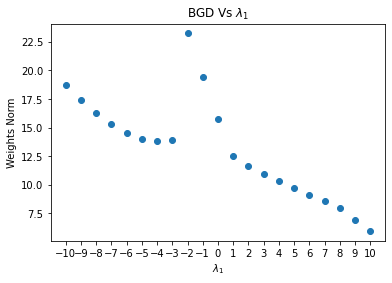

In [29]:
l1_values = range(-10, 11)
l1_norms = []
for l1_lambda in tqdm(l1_values):
    model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=32, l1_lambda=l1_lambda)
    theta, _, _, _ = model.train(X_train, Y_train)
    l1_norms.append(np.sqrt(np.sum(theta**2)))

plt.scatter(l1_values, l1_norms)
plt.xlabel("$\lambda_1$")
plt.ylabel("Weights Norm")
plt.xticks(l1_values)
plt.title("BGD Vs $\lambda_1$")
plt.show()

In [30]:
model._theta

array([[-5.93687628e+00],
       [-1.72735789e-02],
       [ 5.69807021e-03],
       [ 2.33694215e-03]])

### BGD Vs $\lambda_2$

100%|██████████| 14/14 [01:45<00:00,  7.56s/it]


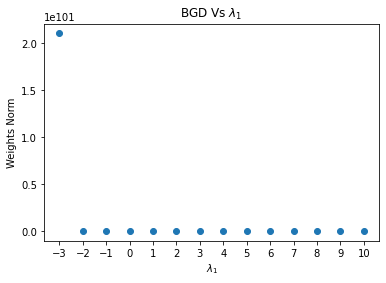

In [31]:
l2_values = range(-3, 11)
l2_norms = []
for l2_lambda in tqdm(l2_values):
    model = RegularizedLR(max_iters=10000, lr=0.001, tolerance=0.00001, batch_size=32, l2_lambda=l2_lambda)
    theta, _, _, _ = model.train(X_train, Y_train)
    l2_norms.append(np.sqrt(np.sum(theta**2)))


plt.scatter(l2_values, l2_norms)
plt.xlabel("$\lambda_1$")
plt.ylabel("Weights Norm")
plt.xticks(l2_values)
plt.title("BGD Vs $\lambda_1$")
plt.show()

In [32]:
model._theta

array([[-1.28649876],
       [-1.20272255],
       [ 0.70149308],
       [ 0.52470853]])

**Question**:

What is the difference between the weights? Which model has more sparse weights?

**Answer**:

The weights produced with L1 Regularization are much smaller than the weights produced with L2 Regularization. And the L1 model's weights are much sparse than L2 model's weights. 

# Step 04

## J

In [33]:
def plot_loss_curves(model, x_train, y_train, x_test, y_test):
    _, train_costs, weights, biases = model.train(x_train, y_train)
    test_costs = [model.mse_loss(x_test@theta + bias, y_test) for theta, bias in zip(weights, biases)]
    # plot learning curve
    plt.plot(train_costs, label="train loss")
    plt.plot(test_costs, label="test loss")
    plt.xlabel("# batches")
    plt.ylabel("MSE Error")
    plt.title("Train Loss Vs Test Loss")
    plt.legend()
    plt.show()

In [34]:
X_train, X_test, Y_train, Y_test = split_data(df, split_ratio=0.2)

print("Train Features Shape:", X_train.shape)
print("Train Labels Shape  :", Y_train.shape)
print("Test Features Shape :", X_test.shape)
print("Test Labels Shape   :", Y_test.shape)

Train Features Shape: (7655, 4)
Train Labels Shape  : (7655, 1)
Test Features Shape : (1872, 4)
Test Labels Shape   : (1872, 1)


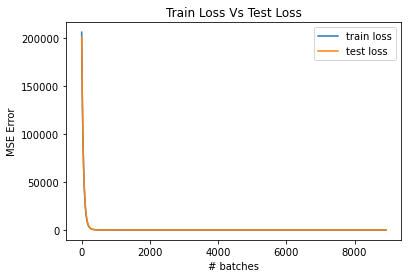

In [35]:
model = LinearRegression(max_iters=10000, lr=0.01, tolerance=0.00001, batch_size=128)
plot_loss_curves(model, X_train, Y_train, X_test, Y_test)

## K

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


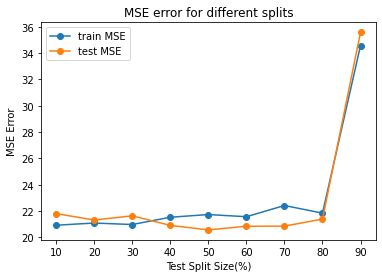

In [36]:
train_mse = []
test_mse = []
split_sizes = np.arange(0.1, 1, 0.1)
model = LinearRegression(max_iters=1000, lr=0.01, tolerance=0.00001, batch_size=32)
for split_size in tqdm(split_sizes):
    X_train, X_test, Y_train, Y_test = split_data(df, split_ratio=split_size)
    model.train(X_train, Y_train)
    train_mse.append( model.mse_loss(model.predict(X_train), Y_train) )
    test_mse.append( model.mse_loss(model.predict(X_test), Y_test) )

# plot learning curve
plt.plot(split_sizes*100, train_mse, label="train MSE", marker='o')
plt.plot(split_sizes*100, test_mse, label="test MSE", marker='o')
plt.xlabel("Test Split Size(%)")
plt.ylabel("MSE Error")
plt.title("MSE error for different splits")
plt.legend()
plt.show()

## L

In [37]:
df_poly2 = df.copy()
for x in df.columns:
    if x == "PE": continue
    df_poly2[x+"^2"] = df[x]**2

df_poly2.head()

,AT,V,AP,RH,PE,AT^2,V^2,AP^2,RH^2
0,14.96,41.76,1024.07,73.17,463.26,223.8016,1743.8976,1.048719e+06,5353.8489
1,25.18,62.96,1020.04,59.08,444.37,634.0324,3963.9616,1.040482e+06,3490.4464
2,5.11,39.40,1012.16,92.14,488.56,26.1121,1552.3600,1.024468e+06,8489.7796
3,20.86,57.32,1010.24,76.64,446.48,435.1396,3285.5824,1.020585e+06,5873.6896
4,10.82,37.50,1009.23,96.62,473.90,117.0724,1406.2500,1.018545e+06,9335.4244


In [38]:
df_poly2_3 = df_poly2.copy()
for x in df.columns:
    if x == "PE": continue
    df_poly2_3[x+"^3"] = df[x]**3

df_poly2_3.head()

,AT,V,AP,RH,PE,AT^2,V^2,AP^2,RH^2,AT^3,V^3,AP^3,RH^3
0,14.96,41.76,1024.07,73.17,463.26,223.8016,1743.8976,1.048719e+06,5353.8489,3348.071936,72825.163776,1.073962e+09,391741.124013
1,25.18,62.96,1020.04,59.08,444.37,634.0324,3963.9616,1.040482e+06,3490.4464,15964.935832,249571.022336,1.061333e+09,206215.573312
2,5.11,39.40,1012.16,92.14,488.56,26.1121,1552.3600,1.024468e+06,8489.7796,133.432831,61162.984000,1.036925e+09,782248.292344
3,20.86,57.32,1010.24,76.64,446.48,435.1396,3285.5824,1.020585e+06,5873.6896,9077.012056,188329.583168,1.031036e+09,450159.570944
4,10.82,37.50,1009.23,96.62,473.90,117.0724,1406.2500,1.018545e+06,9335.4244,1266.723368,52734.375000,1.027946e+09,901988.705528


In [39]:
df_poly2_3_4 = df_poly2_3.copy()
for x in df.columns:
    if x == "PE": continue
    df_poly2_3_4[x+"^4"] = df[x]**4

df_poly2_3_4.head()

,AT,V,AP,RH,PE,AT^2,V^2,AP^2,RH^2,AT^3,V^3,AP^3,RH^3,AT^4,V^4,AP^4,RH^4
0,14.96,41.76,1024.07,73.17,463.26,223.8016,1743.8976,1.048719e+06,5353.8489,3348.071936,72825.163776,1.073962e+09,391741.124013,50087.156163,3.041179e+06,1.099812e+12,2.866370e+07
1,25.18,62.96,1020.04,59.08,444.37,634.0324,3963.9616,1.040482e+06,3490.4464,15964.935832,249571.022336,1.061333e+09,206215.573312,401997.084250,1.571299e+07,1.082602e+12,1.218322e+07
2,5.11,39.40,1012.16,92.14,488.56,26.1121,1552.3600,1.024468e+06,8489.7796,133.432831,61162.984000,1.036925e+09,782248.292344,681.841766,2.409822e+06,1.049534e+12,7.207636e+07
3,20.86,57.32,1010.24,76.64,446.48,435.1396,3285.5824,1.020585e+06,5873.6896,9077.012056,188329.583168,1.031036e+09,450159.570944,189346.471488,1.079505e+07,1.041593e+12,3.450023e+07
4,10.82,37.50,1009.23,96.62,473.90,117.0724,1406.2500,1.018545e+06,9335.4244,1266.723368,52734.375000,1.027946e+09,901988.705528,13705.946842,1.977539e+06,1.037434e+12,8.715015e+07


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


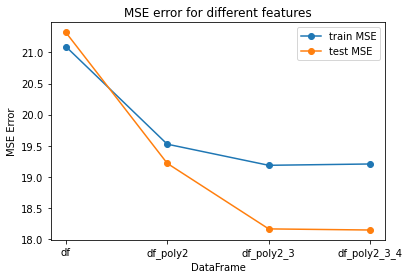

In [40]:
train_mse = []
test_mse = []
split_sizes = np.arange(0.1, 1, 0.1)
model = LinearRegression(max_iters=1000, lr=0.01, tolerance=0.00001, batch_size=32)

for curr_df in tqdm([df, df_poly2, df_poly2_3, df_poly2_3_4]):
    X_train, X_test, Y_train, Y_test = split_data(curr_df, split_ratio=0.2)
    model.train(X_train, Y_train)
    train_mse.append( model.mse_loss(model.predict(X_train), Y_train) )
    test_mse.append( model.mse_loss(model.predict(X_test), Y_test) )

# plot learning curve
labels = ["df", "df_poly2", "df_poly2_3", "df_poly2_3_4"]
plt.plot(labels, train_mse, label="train MSE", marker='o')
plt.plot(labels, test_mse, label="test MSE", marker='o')
plt.xlabel("DataFrame")
plt.ylabel("MSE Error")
plt.title("MSE error for different features")
plt.legend()
plt.show()

100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


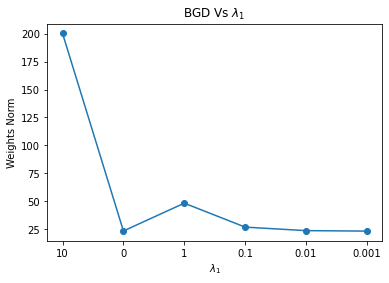

In [41]:
l1_values = [10, 0, 1, 0.1, 0.01, 0.001]
l1_costs = []
X_train, X_test, Y_train, Y_test = split_data(curr_df, split_ratio=0.2)
for l1_lambda in tqdm(l1_values):
    model = RegularizedLR(max_iters=1000, lr=0.001, tolerance=0.00001, batch_size=32, l1_lambda=l1_lambda)
    model.train(X_train, Y_train)
    test_mse = model.mse_loss(model.predict(X_test), Y_test)
    l1_costs.append(test_mse)


plt.plot([str(x) for x in l1_values], l1_costs, marker='o')
plt.xlabel("$\lambda_1$")
plt.ylabel("Weights Norm")
plt.title("BGD Vs $\lambda_1$")
plt.show()

100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


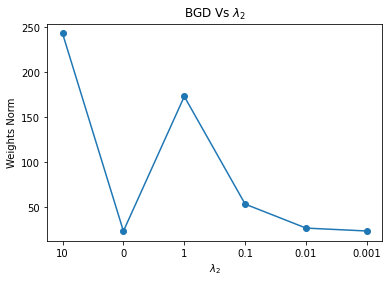

In [42]:
l2_values = [10, 0, 1, 0.1, 0.01, 0.001]
l2_costs = []
X_train, X_test, Y_train, Y_test = split_data(curr_df, split_ratio=0.2)
for l2_lambda in tqdm(l2_values):
    model = RegularizedLR(max_iters=1000, lr=0.001, tolerance=0.00001, batch_size=32, l2_lambda=l2_lambda)
    model.train(X_train, Y_train)
    test_mse = model.mse_loss(model.predict(X_test), Y_test)
    l2_costs.append(test_mse)


plt.plot([str(x) for x in l2_values], l2_costs, marker='o')
plt.xlabel("$\lambda_2$")
plt.ylabel("Weights Norm")
plt.title("BGD Vs $\lambda_2$")
plt.show()

**Question**:

What value of lambda gives the best model and the corresponding MSE on the validation data?

**Answer**:

For both L1 regularization and L2 regularization, the value `0.01` was the one that got the least test MSE.

In [43]:
i = 1e-9
learning_rates = []
while(i < 2):
    learning_rates.append(i)
    i *= 10

print(learning_rates)

[1e-09, 1e-08, 1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0]


100%|██████████| 10/10 [00:00<00:00, 465.39it/s]


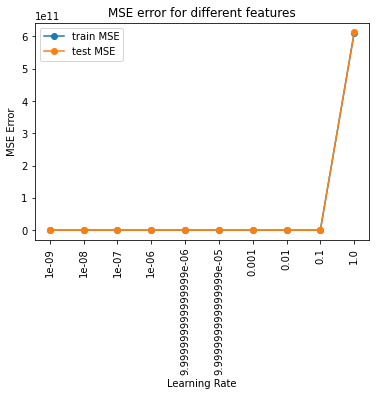

In [44]:
train_mse = []
test_mse = []
X_train, X_test, Y_train, Y_test = split_data(df, split_ratio=0.2)
for lr in tqdm(learning_rates):
    model = LinearRegression(max_iters=3, lr=lr, tolerance=0.00001, batch_size=32)
    model.train(X_train, Y_train)
    train_mse.append( model.mse_loss(model.predict(X_train), Y_train) )
    test_mse.append( model.mse_loss(model.predict(X_test), Y_test) )

# plot learning curve
labels = [str(lr) for lr in learning_rates]
plt.plot(labels, train_mse, label="train MSE", marker='o')
plt.plot(labels, test_mse, label="test MSE", marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("MSE Error")
plt.title("MSE error for different features")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Step 5

In [45]:
def cross_validation(df, kfold):
    folds = []
    X, Y = preprocess_data(df)
    fold_size = len(X)//kfold
    # folds is a list of (trainset, testset) where each item is a tuple of (features, labels)
    for i in range(1, kfold):
        # test set
        test_start_idx = (i-1)*fold_size
        test_end_idx = i*fold_size
        test_features = X[test_start_idx:test_end_idx]
        test_labels = Y[test_start_idx:test_end_idx]
        testset = (test_features, test_labels)
        
        # train set
        idx = 0 if i <= 0 else test_start_idx
        train_features = np.concatenate((X[:idx], X[test_end_idx:]), axis=0)
        train_labels =   np.concatenate((Y[:idx], Y[test_end_idx:]), axis=0)
        trainset = (train_features, train_labels)
        
        folds.append( (trainset, testset) )
    return folds

In [46]:
l1_values = [10, 1, 0.1, 0.01, 0.001]
avg_mse = []
for l1 in tqdm(l1_values):
    test_mse = []
    for trainset, testset in cross_validation(df, 7):
        X_train, Y_train = trainset
        X_test, Y_test = testset
        model = RegularizedLR(max_iters=1000, lr=0.001, tolerance=0.00001, batch_size=32, l1_lambda=l1_lambda)
        model.train(X_train, Y_train)
        pred = model.predict(X_test)
        test_mse.append( model.mse_loss(pred, Y_test) )
    avg_mse.append( np.mean(test_mse) )
#     break

avg_mse

100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


[27.5652802506647,
 27.455539157815537,
 27.827456294173473,
 27.494907833128618,
 27.653558741062856]

In [47]:
l1_values[np.argmin(avg_mse)] #the best value

1